Per Capita Income Consolidation (1950–Present)

Countries: Singapore, Taiwan, South Korea, Japan

This notebook fetches and consolidates per capita income data from DGBAS and World Bank into an Excel file.

In [58]:
# Core dependencies
!pip install pandas
!pip install openpyxl

# Data source
!pip install wbdata
!pip install pandas wbdata openpyxl

# Visualization
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


📘 Step 1: Replace DGBAS.xlsx file and clean Taiwan GNI Data from DGBAS.xlsx into Taiwan.xlsx

In [59]:
## Import necessary libraries
import pandas as pd

# Load the raw DGBAS file
raw_df = pd.read_excel("dgbas.xlsx", header=None)

# Extract the useful data range
# Real data starts at row 4 (index 4)
data_block = raw_df.iloc[4:, [0, 1, 9, 11]]
data_block.columns = ["Year", "Population", "GNI_CurrentUSD_million", "PerCapitaGNI_CurrentUSD"]

# Drop rows where Year is not a valid number
data_block = data_block[pd.to_numeric(data_block["Year"], errors="coerce").notna()]
data_block["Year"] = data_block["Year"].astype(int)

# Add additional required columns for standardization
data_block["Country"] = "Taiwan"
data_block["Source"] = "DGBAS"
data_block["PerCapitaIncome_ConstantUSD"] = None
data_block["GDP_CurrentUSD"] = None
data_block["PPP_Adjusted"] = None

# Reorder columns (renaming the GNI field accordingly)
taiwan_clean = data_block[[ 
    "Country", "Year", "PerCapitaGNI_CurrentUSD", "PerCapitaIncome_ConstantUSD",
    "GDP_CurrentUSD", "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
]]

# Save to Excel
taiwan_clean.to_excel("taiwan_gni.xlsx", index=False)
print("✅ Saved cleaned Taiwan GNI data to taiwan_gni.xlsx")

✅ Saved cleaned Taiwan GNI data to taiwan_gni.xlsx


🌍 Step 2: Fetch GNI per Capita for SG, JP, KR (World Bank via wbdata)

In [60]:
# Import libraries
import pandas as pd
import wbdata
import datetime

# Indicator and date range (GNI per capita, current USD)
indicator = {"NY.GNP.PCAP.CD": "PerCapitaGNI_CurrentUSD"}
data_date = (datetime.datetime(1960, 1, 1), datetime.datetime(2023, 1, 1))

# Country ISO3 codes
countries = {
    "SGP": "Singapore",
    "JPN": "Japan",
    "KOR": "Korea"
}

# Fetch data for each country
def fetch_from_wb(iso_list, country_name):
    df = wbdata.get_dataframe(indicator, country=iso_list, date=data_date)
    df.reset_index(inplace=True)
    df = df.rename(columns={
        "date": "Year",
        "country": "CountryCode",
        list(indicator.values())[0]: "PerCapitaGNI_CurrentUSD"
    })

    df["Year"] = pd.to_datetime(df["Year"]).dt.year
    df["Country"] = country_name
    df["Source"] = "World Bank (wbdata)"
    df["PerCapitaIncome_ConstantUSD"] = None
    df["Population"] = None
    df["PPP_Adjusted"] = None
    df["GNI_CurrentUSD_million"] = None

    return df[[ 
        "Country", "Year", "PerCapitaGNI_CurrentUSD", "PerCapitaIncome_ConstantUSD",
        "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
    ]]

# Apply to all 3 countries
sg_df = fetch_from_wb(["SGP"], "Singapore")
jp_df = fetch_from_wb(["JPN"], "Japan")
kr_df = fetch_from_wb(["KOR"], "Korea")

# Combine and export
combined_gni = pd.concat([sg_df, jp_df, kr_df])
combined_gni.to_excel("openbb_countries.xlsx", index=False)
print("✅ Saved World Bank GNI data to openbb_countries.xlsx")

✅ Saved World Bank GNI data to openbb_countries.xlsx


🔗 Step 3: Combine Taiwan + World Bank Data

In [62]:
# Load both data sources
taiwan = pd.read_excel("taiwan_gni.xlsx")
openbb_countries = pd.read_excel("openbb_countries.xlsx")

# Define a clean prep function
def prepare_combined_data(taiwan_df, worldbank_df):
    combined = pd.concat([taiwan_df, worldbank_df], ignore_index=True)
    combined["Country"] = combined["Country"].replace({"Korea": "South Korea"})
    combined = combined.sort_values(["Country", "Year"]).reset_index(drop=True)
    return combined

# 🔁 Centralized data cleaning
combined = prepare_combined_data(taiwan, openbb_countries)

# Apply deduplication globally
combined = combined.drop_duplicates(subset=["Country", "Year"])

# ✅ Export long format (deduped)
combined.to_excel("per_capita_income_long.xlsx", index=False) #long format (raw)
print("✅ Saved long format data to per_capita_income_long.xlsx")

# ✅ Export wide format
comparison_df = combined.pivot_table(
    index="Year",
    columns="Country",
    values="PerCapitaGNI_CurrentUSD",
    aggfunc="mean"
)
comparison_df = comparison_df[["Japan", "Singapore", "South Korea", "Taiwan"]]
comparison_df.to_excel("per_capita_income_comparison.xlsx") #wide format (visual comparison)
print("✅ Saved comparison data to per_capita_income_comparison.xlsx")

✅ Saved long format data to per_capita_income_long.xlsx
✅ Saved comparison data to per_capita_income_comparison.xlsx


In [63]:
# ✅ Sanity check: compare wide vs long format
comparison_long = comparison_df.reset_index().melt(id_vars="Year", var_name="Country", value_name="GNI_Wide")

# Merge long and wide formats
merged = pd.merge(
    comparison_long,
    combined[["Country", "Year", "PerCapitaGNI_CurrentUSD"]],
    on=["Country", "Year"],
    how="outer"
)

# Drop rows with any missing values before comparison
merged = merged.dropna(subset=["GNI_Wide", "PerCapitaGNI_CurrentUSD"])

# Check match within float tolerance
merged["Match"] = (merged["GNI_Wide"] - merged["PerCapitaGNI_CurrentUSD"]).abs() <= 1.5

# Show mismatches
mismatches = merged[~merged["Match"]]
print(f"❌ {len(mismatches)} mismatches found between long and wide format (ignoring missing values).")
display(mismatches)


❌ 0 mismatches found between long and wide format (ignoring missing values).


,Year,Country,GNI_Wide,PerCapitaGNI_CurrentUSD,Match


📊 Optional: Preview Cleaned Data

In [65]:
# Load final dataset
# df = pd.read_excel("per_capita_income_long.xlsx")
df = pd.read_excel("per_capita_income_comparison.xlsx")
df.head(10)

,Year,Japan,Singapore,South Korea,Taiwan
0,1951,NaN,NaN,NaN,154
1,1952,NaN,NaN,NaN,208
2,1953,NaN,NaN,NaN,178
3,1954,NaN,NaN,NaN,188
4,1955,NaN,NaN,NaN,216
5,1956,NaN,NaN,NaN,151
6,1957,NaN,NaN,NaN,170
7,1958,NaN,NaN,NaN,184
8,1959,NaN,NaN,NaN,140
9,1960,NaN,NaN,NaN,163


📈 Optional: Plot GNI Per Capita Over Time (Current USD)

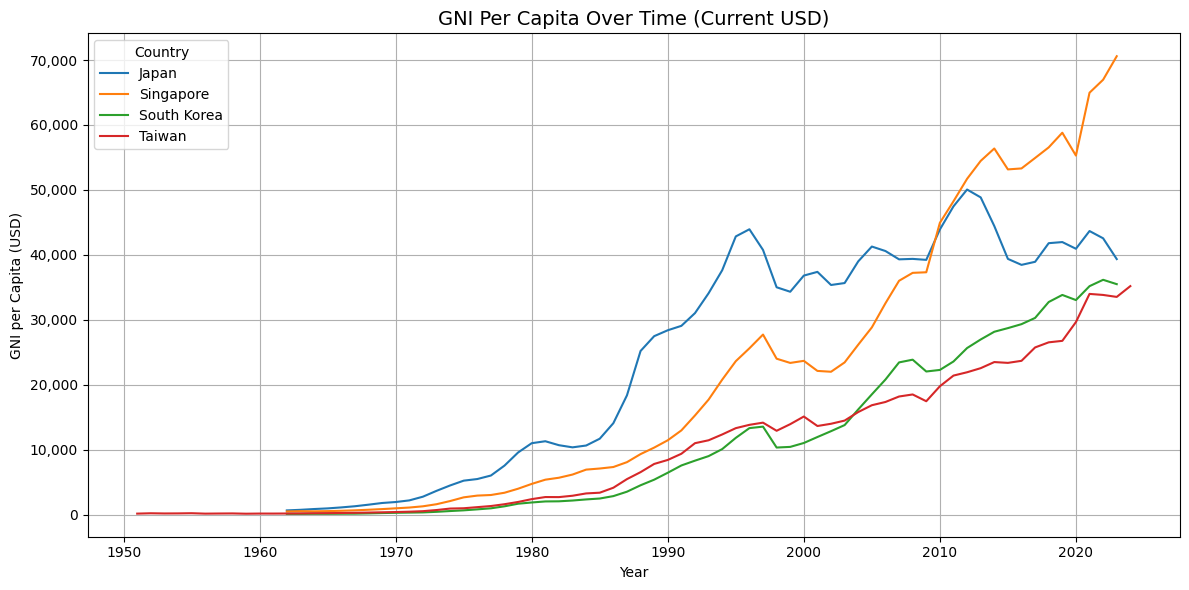

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot: GNI Per Capita over Time
plt.figure(figsize=(12, 6))

# Sort countries for consistent legend order
for country in sorted(combined["Country"].unique()):
    subset = combined[combined["Country"] == country].sort_values("Year")
    plt.plot(subset["Year"], subset["PerCapitaGNI_CurrentUSD"], label=country)

plt.title("GNI Per Capita Over Time (Current USD)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("GNI per Capita (USD)")
plt.legend(title="Country")
plt.grid(True)

# Format y-axis with commas (e.g., 20,000)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

📉 Optional: Histogram of GNI Per Capita (All Years)

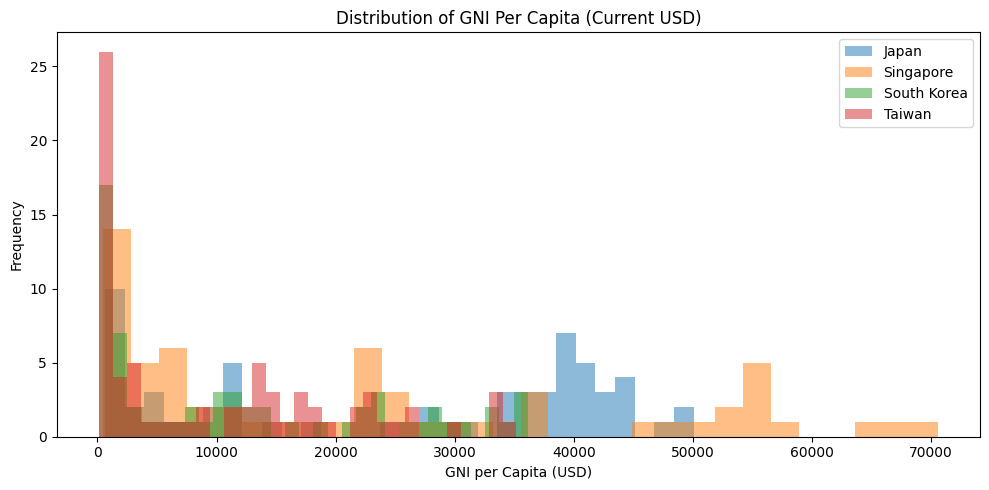

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for country in combined["Country"].unique():
    subset = combined[combined["Country"] == country]
    plt.hist(subset["PerCapitaGNI_CurrentUSD"].dropna(), bins=30, alpha=0.5, label=country)

plt.title("Distribution of GNI Per Capita (Current USD)")
plt.xlabel("GNI per Capita (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

📊 Optional: Show Data Summary by Country

In [68]:
combined.groupby("Country")["PerCapitaGNI_CurrentUSD"].describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Japan,62.0,25024.032258,17165.731060,650.0,6402.5,32560.0,39380.0,50060.0
Singapore,62.0,22276.612903,21501.971312,490.0,3107.5,16490.0,36925.0,70590.0
South Korea,62.0,11847.258065,11928.011964,120.0,1047.5,8660.0,22220.0,36160.0
Taiwan,74.0,9982.756757,10524.388830,140.0,366.0,6004.5,17221.0,35188.0
